In [ ]:
# this notebook contains different clustering approaches in order to digest large datasets

In [27]:
!pip install -qU bertopic pandas nltk scikit-learn matplotlib xlwt faiss-gpu

In [2]:
import pandas as pd
docs = pd.read_csv('gs://axels_bucket/news_dataset/news.csv')
docs = docs.dropna()
docs

,date,url,content,domain
0,2021-08-09,http://en.people.cn/n3/2021/0808/c90000-988149...,more farm products meet national standards in ...,en.people.cn
1,2021-08-09,https://www.dailymail.co.uk/news/article-98764...,health chiefs recall another 25 batches of blo...,www.dailymail.co.uk
2,2021-08-09,https://www.envirotech-online.com/article/envi...,'forever chemicals' - its time for action on p...,www.envirotech-online.com
3,2021-08-09,https://www.bristolpost.co.uk/news/uk-world-ne...,common blood pressure drug recalled due to can...,www.bristolpost.co.uk
4,2021-08-09,https://www.nutritioninsight.com/audios/newsbi...,newsbite aug 2-6: us food labeling modernizati...,www.nutritioninsight.com
...,...,...,...,...
92717,2024-04-14,https://kswfoodmicro.com/2024/04/14/research-o...,research officials confirm planned closure of ...,kswfoodmicro.com
92718,2024-04-14,https://sundiatapost.com/fg-needs-nigerians-su...,fg needs nigerians to make lives better mohamm...,sundiatapost.com
92719,2024-04-14,https://www.thesouthafrican.com/news/sahpra-re...,sahpra recalls benylin paediatric syrup with t...,www.thesouthafrican.com
92720,2024-04-15,https://www.channelnewsasia.com/singapore/gen-...,"the big read: call me maybe - gen zers, millen...",www.channelnewsasia.com


In [12]:
def get_first_n_terms(text):
    words = text.split()[:200]  # Split the text into words and take the first n
    return ' '.join(words)

# Applying the function to the 'text' column and creating a new column 'first_100_words'
docs['beginning'] = docs['content'].apply(get_first_n_terms)
docs['beginning'][2]

"'forever chemicals' - its time for action on pfas - jul 26 2021 - graham meller - environmental science news - envirotech online product search e-learning white papers sign-in news section environmental laboratory environmental laboratory soil testing food safety testing pfas analysis microplastics analysis environmental laboratory soil testing food safety testing pfas analysis microplastics analysis latest in environmental laboratory fully automated e. coli and enterococci monitoring glass expansion hydramist spray chamber: enhancing i... waterwastewater waterwastewater water quality monitoring water quality monitoring drinking water water pollution monitoring water pollution monitoring river water monitoring sewage monitoring water testing water testing pfas in water groundwater monitoring wastewater analysis water monitoring waterwastewater water quality monitoring water pollution monitoring water testing groundwater monitoring wastewater analysis water monitoring drinking water ri

In [13]:
import pandas as pd
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
from umap import UMAP
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean
import nltk
import re

In [14]:
# Function to group by a specific time unit (Year, Month, Day)
def group_by_time_unit(df, time_unit):
    if time_unit == 'year':
        return df['date'].dt.year
    elif time_unit == 'month':
        return df['date'].dt.to_period('M')  # Month as YYYY-MM
    elif time_unit == 'day':
        return df['date'].dt.date  # Exact day as YYYY-MM-DD
    else:
        raise ValueError("Invalid time_unit. Choose 'year', 'month', or 'day'.")

In [15]:
def time_difference(max_time, min_time, time_unit):
    if time_unit == 'year':
        return max_time - min_time  # Directly subtract the years since they are integers
    elif time_unit == 'month':
        return (max_time.year - min_time.year) * 12 + (max_time.month - min_time.month)  # Total months
    elif time_unit == 'day':
        return (max_time - min_time).days  # Difference in days
    else:
        raise ValueError("Invalid time unit for difference. Choose 'year', 'month', or 'day'.")

In [16]:
# Convert the 'Abstract' column to string data type
docs['text'] = docs['beginning'].astype(str)

# Define a regular expression pattern to match non-Latin characters
non_latin_pattern = re.compile(r'[^\x00-\x7F]')

# Apply the regular expression pattern to the 'Abstract' column
docs = docs[~docs['text'].str.contains(non_latin_pattern)]

# Set the time unit for grouping (year, month, or day)
time_unit = 'month'  # Change this to 'year', 'month', or 'day'

# Convert the 'Date' column to datetime and drop invalid dates
docs['date'] = pd.to_datetime(docs['date'], errors='coerce')
docs.dropna(subset=['date'], inplace=True)

# Group data based on the selected time unit
docs['Time'] = group_by_time_unit(docs, time_unit)

text = docs["text"].astype('str')
text = text.tolist()

In [17]:
#HDBSCAN with parameter tuning
from hdbscan import HDBSCAN
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(text, show_progress_bar=False)
cluster_model = HDBSCAN(
    min_cluster_size=2,       # Allow small clusters
    min_samples=1,            # Increase sensitivity to noise
    cluster_selection_epsilon=0.1,  # Fine-tune for smaller clusters
    metric='euclidean'
)

topic_model = BERTopic(hdbscan_model=cluster_model,  calculate_probabilities=False).fit(text, embeddings)
topic_info = topic_model.get_topic_info()

doc_info = topic_model.get_document_info(text)
doc_info["ID"] = doc_info.index
doc_info["Time"] = docs["Time"].tolist()

In [29]:
#HDBSCAN with parameter tuning
from hdbscan import HDBSCAN
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(text, show_progress_bar=False)
cluster_model = HDBSCAN(
    min_cluster_size=2,       # Allow small clusters
    min_samples=1,            # Increase sensitivity to noise
    cluster_selection_epsilon=0.05,  # Fine-tune for smaller clusters
    metric='euclidean'
)

topic_model = BERTopic(hdbscan_model=cluster_model,  calculate_probabilities=False).fit(text, embeddings)
topic_info2 = topic_model.get_topic_info()

doc_info2 = topic_model.get_document_info(text)
doc_info2["ID"] = doc_info2.index
doc_info2["Time"] = docs["Time"].tolist()

In [39]:
#Try3 Approximate Nearest Neighbors (ANN) Clustering
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import faiss

# Load your data
# text = [...]  # Your list of 100k newspaper headlines

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(text, show_progress_bar=True, batch_size=32)
embeddings = np.array(embeddings).astype('float32')

# Corrected Custom FAISS Clustering Class
class FaissKMeans:
    def __init__(self, n_clusters=1000, n_iter=20, gpu=False):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.gpu = gpu
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, embeddings, y=None):
        d = embeddings.shape[1]

        if self.gpu:
            res = faiss.StandardGpuResources()
            flat_config = faiss.GpuIndexFlatConfig()
            flat_config.device = 0
            index = faiss.GpuIndexFlatL2(res, d, flat_config)
        else:
            index = faiss.IndexFlatL2(d)

        kmeans = faiss.Clustering(d, self.n_clusters)
        kmeans.niter = self.n_iter
        kmeans.max_points_per_centroid = 10000000  # Avoid subsampling
        kmeans.verbose = False  # Suppress faiss output

        # Ensure embeddings are float32
        embeddings = embeddings.astype(np.float32)

        # Train the clustering model
        kmeans.train(embeddings, index)

        # Store the cluster centers
        self.cluster_centers_ = faiss.vector_to_array(kmeans.centroids).reshape(self.n_clusters, d)

        # Assign cluster centers to the index
        index.add(self.cluster_centers_)

        # Assign embeddings to clusters
        distances, labels = index.search(embeddings, 1)
        labels = labels.flatten()

        # Store the labels
        self.labels_ = labels

        return self

    def predict(self, embeddings):
        embeddings = embeddings.astype(np.float32)
        d = embeddings.shape[1]

        if self.gpu:
            res = faiss.StandardGpuResources()
            flat_config = faiss.GpuIndexFlatConfig()
            flat_config.device = 0
            index = faiss.GpuIndexFlatL2(res, d, flat_config)
        else:
            index = faiss.IndexFlatL2(d)

        index.add(self.cluster_centers_)
        distances, labels = index.search(embeddings, 1)
        labels = labels.flatten()
        return labels

    def fit_predict(self, embeddings, y=None):
        self.fit(embeddings, y)
        return self.labels_

# Initialize the custom clustering model
cluster_model = FaissKMeans(n_clusters=1000, n_iter=20, gpu=False)

# Initialize the vectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=3)

# Initialize and fit the BERTopic model
topic_model = BERTopic(
    hdbscan_model=cluster_model,
    umap_model=None,
    low_memory=True,
    calculate_probabilities=False,
    vectorizer_model=vectorizer_model
)

topics, probs = topic_model.fit_transform(text, embeddings)

# Get topic and document information
topic_info3 = topic_model.get_topic_info()
doc_info3 = topic_model.get_document_info(text)
doc_info3["ID"] = doc_info3.index
doc_info3["Time"] = docs["Time"].tolist()

Batches:   0%|          | 0/2882 [00:00<?, ?it/s]

In [43]:
# Split the data based on the selected time unit
paper_split = dict(tuple(doc_info3.groupby('Time')))

# Get the maximum time value (e.g., year, month, or day)
max_time = doc_info3['Time'].max()

# Initialize an empty DataFrame
dov = pd.DataFrame()

# Create a list to store individual DataFrames for each time group (year, month, or day)
dfs = []

# Set the time weight (tw)
tw = 0.05

# Iterate over each time group's data
for time_value, group in doc_info3.groupby('Time'):
    topic_count = group['Name'].value_counts().reset_index()
    topic_count.columns = ['Name', 'Count']
    topic_count['Time'] = time_value

    # Get min and max time for this group
    min_time = group['Time'].min()
    max_time = group['Time'].max()

    # Calculate the time difference (based on the time unit)
    time_diff = time_difference(max_time, min_time, time_unit)

    # Create a DataFrame for the current time's DoV values
    df = pd.DataFrame(index=[min_time], columns=topic_count['Name'])
    for _, row in topic_count.iterrows():
        topic = row['Name']
        frequency = row['Count']
        # Ensure the time difference is factored in correctly
        df[topic] = (frequency / len(group)) * (1 - tw * time_diff)

    dfs.append(df)

# Concatenate all the time-based DataFrames into a single DataFrame
dov = pd.concat(dfs)

# Compute the geometric mean for each topic across time units
dov_means = pd.DataFrame(columns=dov.columns)

for column in dov.columns:
    column_mean = gmean(dov[column].dropna())
    dov_means[column] = [column_mean * 1000]

t_DoV = dov_means.melt(var_name="Name", value_name="dov")

# Merge with topic information
wsm_dov = pd.merge(t_DoV, topic_info3, on='Name')
wsm_dov

,Name,dov,Topic,Count,Representation,Representative_Docs
0,76_dog_dogs_pet_dog food,1.730655,76,217,"[dog, dogs, pet, dog food, pet food, purina, c...",[fda says recalled pet food may be linked to 1...
1,1_word_cryptocurrencies_indicates_word markets,3.919238,1,464,"[word, cryptocurrencies, indicates, word marke...",[workcred releases four-part series on the imp...
2,41_cards_buying guides_originals_highest,2.177887,41,254,"[cards, buying guides, originals, highest, buy...",[grilling your food wrong how to prepare that ...
3,36_cards_buying guides_originals_highest,3.752151,36,262,"[cards, buying guides, originals, highest, buy...",[saturday is national hamburger day. here's wh...
4,462_shrimp_frozen shrimp_frozen_avanti,0.749235,462,77,"[shrimp, frozen shrimp, frozen, avanti, avanti...",[major expanded recall on frozen shrimp sold a...
...,...,...,...,...,...,...
995,997_jax_news jax_action news_unavailable location,0.583090,997,2,"[jax, news jax, action news, unavailable locat...",[this website is unavailable in your location....
996,962_jax_news jax_action news_unavailable location,0.714956,962,10,"[jax, news jax, action news, unavailable locat...",[this website is unavailable in your location....
997,939_companies products_services software_produ...,1.130652,939,13,"[companies products, services software, produc...",[certified reference materials for the quantif...
998,284_quaker_granola_quaker oats_oats,8.876800,284,118,"[quaker, granola, quaker oats, oats, granola b...",[quaker oats recalls more products over potent...


In [44]:
wsm_dov.to_csv('data/wsm_dov3.csv', index=False)

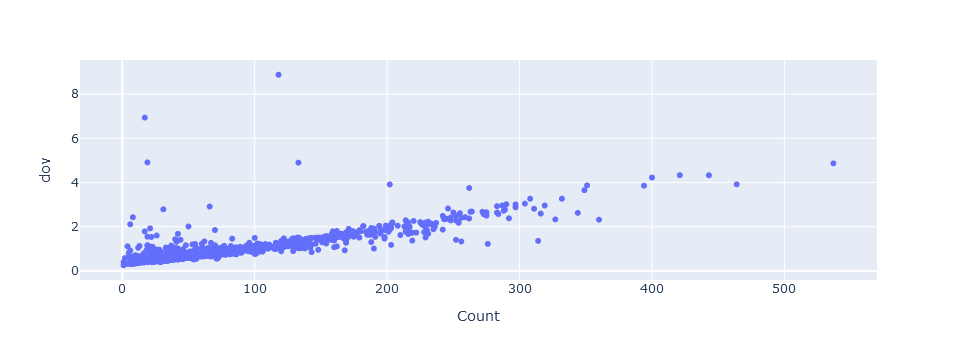

In [45]:
import plotly.express as px

# Create the scatter plot using Plotly
fig = px.scatter(wsm_dov, x='Count', y='dov', hover_data=['Name'])

# Show the plot
fig.show()

In [49]:
# Set the desired range for 'dov' and 'frequency'
dov_min = 1
count_min = 10
count_max = 65

# Filter the DataFrame based on the range of values
weak_signal_df = wsm_dov[(wsm_dov['dov'] >= dov_min) & (wsm_dov['Count'] >= count_min) & (wsm_dov['Count'] <= count_max)]

# Get the values from the 'term' column in the filtered DataFrame
weak_signals = weak_signal_df['Name'].values.tolist()
print(len(weak_signal_df))
weak_signal_df

34


,Name,dov,Topic,Count,Representation,Representative_Docs
9,557_20240521_2024 20240521_22 whos_reacting 20...,1.336105,557,62,"[20240521, 2024 20240521, 22 whos, reacting 20...",[- archyde skip to content archyde menu news e...
96,916_brussels times_brussels_times_,1.789366,916,17,"[brussels times, brussels, times, , , , , , , ]","[the brussels times, the brussels times, the b..."
110,721_het_juli_van_dat,1.437229,721,40,"[het, juli, van, dat, pdc, op, wij, aan, nu, z...",[- archyde skip to content archyde menu news e...
194,878_jakubowitz_jakubowitz law_lawsuits_shareho...,1.927237,878,21,"[jakubowitz, jakubowitz law, lawsuits, shareho...","[lawsuits filed against qfin, coin and phg - j..."
423,779_noodls_transportation_execution scripts_bl...,1.062020,779,33,"[noodls, transportation, execution scripts, bl...",[delegation of the european union to albania v...
458,563_derby_derbyshire_buy_derby county,1.044968,563,61,"[derby, derbyshire, buy, derby county, derbyte...",[72 eateries in derbyshire with one-star food ...
518,547_candles_safes_laceration_burn,1.036772,547,65,"[candles, safes, laceration, burn, threshold, ...",[target recalling millions of threshold candle...
620,645_antwerp_fourth place_place house_crew,2.013443,645,50,"[antwerp, fourth place, place house, crew, win...",[- archyde skip to content archyde menu news e...
624,698_human bones_easton_brook_bones,1.679891,698,42,"[human bones, easton, brook, bones, second ann...",[- archyde skip to content archyde menu news e...
721,568_mustard_gm mustard_gm_environmental release,1.029227,568,60,"[mustard, gm mustard, gm, environmental releas...",[scientists write to pm against icar gag order...


In [50]:
weak_signal_df.to_csv('data/weak_signal_df_100k3.csv', index=False)